# Проектная деятельность

Предварительный план:
    1. Исключить коррелированные факторы
    2. Преобразовать факторы необходимым образом
    3. Составить logit-модель
    4. Проверить статистическую значимость модели и параметров
    5. Проверить остатки на гомоскедастичность
    6. (*) Преобразовать с помощью ВМНК
## Импортирую данные


In [63]:
import numpy as np
import pandas as pd
df = pd.read_excel('pd_data.xlsx', index_col=0, sheet_name='Данные', skiprows=3)
features = {'X1': '1, если совокупные обязательства превышают совокупные активы',
            'X2': '1, если за текущий и предшествующий период прибыль отрицательная',
            'X3': 'Мера изменения чистого дохода за последние два года',
            'X4': 'Проценты к уплате/выручка',
            'X5': 'Выручка/дебиторская задолженность',
            'X6': 'Коэффициент текущей ликвидности',
            'X7': 'Коэффициент финансовой независимости',
            'X8': 'Коэффициент рентабельности внеоборотных активов'}
df.index = [list(range(len(df)))]
df.head()

,Y,X1,X2,X3,X4,X5,X6,X7,X8
0,1,1,1,0.112060,0.000000,6.339057,0.630987,-0.369552,-124.489772
1,1,1,0,1.000000,0.000000,4.534888,0.789288,-0.261901,91.378092
2,1,0,0,-0.405078,0.000463,0.941934,1.004983,0.012218,37.310142
3,1,1,1,0.174465,0.000000,0.001031,0.809411,-0.140484,-96.389418
4,1,0,0,0.079430,0.315265,1.970448,0.525311,0.115483,2.417222


## Исключение незначимых факторов

In [64]:
import statsmodels.api as sm
df['intercept'] = 1
data = df.copy()
y_train = data['Y'].to_numpy()
alpha = 0.1
while True:
    x_train = data.drop(['Y'], axis=1).to_numpy()
    model = sm.Logit(y_train, x_train).fit()
    largest_p = max(model.pvalues)
    if largest_p > alpha:
        index = np.argmax(model.pvalues) + 1
        print(f'Dropping column {data.columns[index]} with level of significance {largest_p}')
        data.drop(data.columns[index], axis=1, inplace=True)
    else:
        break

model.summary()

Optimization terminated successfully.
         Current function value: 0.301692
         Iterations 9
Dropping column X4 with level of significance 0.6064371926638968
Optimization terminated successfully.
         Current function value: 0.306553
         Iterations 9
Dropping column intercept with level of significance 0.6292588166997459
Optimization terminated successfully.
         Current function value: 0.309561
         Iterations 9
Dropping column X7 with level of significance 0.6534145938605584
Optimization terminated successfully.
         Current function value: 0.312397
         Iterations 9
Dropping column X8 with level of significance 0.6137347695995858
Optimization terminated successfully.
         Current function value: 0.379899
         Iterations 7
Dropping column X2 with level of significance 0.45618609397163423
Optimization terminated successfully.
         Current function value: 0.387040
         Iterations 7
Dropping column X5 with level of significance 0.3850134

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                   40
Model:                          Logit   Df Residuals:                       37
Method:                           MLE   Df Model:                            2
Date:                Wed, 25 Mar 2020   Pseudo R-squ.:                  0.4241
Time:                        16:17:36   Log-Likelihood:                -15.967
converged:                       True   LL-Null:                       -27.726
Covariance Type:            nonrobust   LLR p-value:                 7.816e-06
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             3.4453      1.212      2.842      0.004       1.069       5.821
x2            -1.8430      0.828     -2.227      0.026      -3.465      -0.221
x3            -0.4504      0.220     -2.043      0.041      -0.882      -0.018
==============================================================================
"""

In [71]:
test_result = [round(value) for value in model.predict(x_train)]
correct_pred = sum([1 for i, j in zip(test_result, y_train) if i == j])

print(f'{correct_pred / len(df) * 100}%')

85.0%


## Проверка на гетероскедастичность

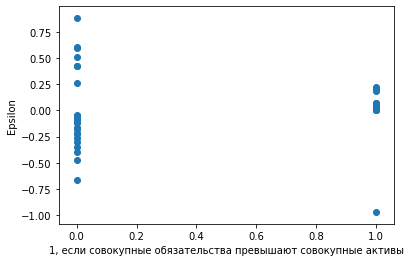

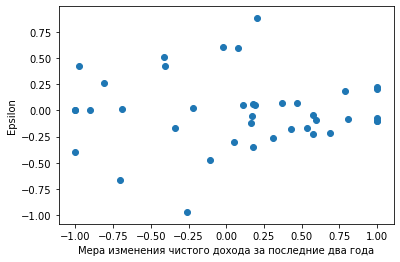

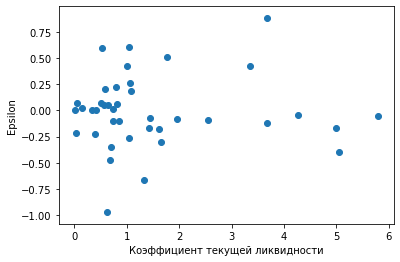

In [66]:
from matplotlib import pylab as plt
import statsmodels.stats.diagnostic as sms 
for column in data.drop('Y', axis=1).columns:
    plt.ylabel('Epsilon')
    plt.xlabel(features[column])
    plt.scatter(data[column], model.resid_generalized)
    plt.show()

In [70]:
from statsmodels.api import OLS
def goldfeldquandt(ys, xs):
    f_cr = 2.09 # Взято из таблицы
    split = len(ys) // 2
    fmodel = OLS(ys[:split], xs[:split]).fit()
    smodel = OLS(ys[split:], xs[split:]).fit()
    f_exp = sum(smodel.resid) / sum(fmodel.resid)
    sign = '>' if f_exp > f_cr else '<'
    return f'F_exp = {f_exp} {sign} F_cr = {f_cr}'

for column in data.drop('Y', axis=1):
    x_test = data.sort_values(column)[column].to_numpy()
    y_test = data.sort_values(column)['Y'].to_numpy()
    print(goldfeldquandt(y_test, x_test))

F_exp = 0.3999999999999999 < F_cr = 2.09
F_exp = 0.5007864970110885 < F_cr = 2.09
F_exp = 0.9086858202225908 < F_cr = 2.09
